In [1]:
import json
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device")

Using 'cuda' device


<hr>

### Loading the MNIST Dataset


In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


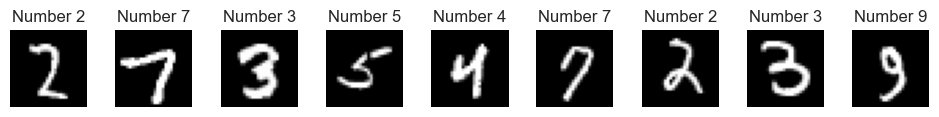

In [5]:
figure = plt.figure(figsize=(12, 1))
cols, rows = 9, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Number {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

<hr>

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, linear_relu_stack : nn.Sequential):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = linear_relu_stack

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 250 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, m):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    m.error_avg.append(test_loss)


<hr>

In [8]:
class Model(NamedTuple):
    name: str
    learning_rate: float
    batch_size: int
    epochs: int
    hidden_layers: list[int]
    error_avg : list[float] = []

    def constructor(self):
        layer_size = self.hidden_layers.copy()
        layer_size.insert(0, 28 * 28)
        layer_size.append(10)

        layers = []
        for i in range(len(layer_size)-2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_size[-2], layer_size[-1]))

        linear_stack = nn.Sequential(*layers)
        return NeuralNetwork(linear_stack)


def load_models(filename: str) -> list[Model]:
    l = []

    with open(filename) as f:
        raw = json.load(f)

    for model_name, param in raw.items():
        m = Model(
            name=model_name,
            learning_rate=param['learning_rate'],
            batch_size=param['batch_size'],
            epochs=param['epochs'],
            hidden_layers=param['hidden_layers']
        )
        l.append(m)
    return l


<hr>

In [9]:
for m in load_models('model.json'):
    model = m.constructor().to(device)
    train_dataloader = DataLoader(training_data, batch_size=m.batch_size)
    test_dataloader = DataLoader(test_data, batch_size=m.batch_size)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=m.learning_rate)

    for t in range(m.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn, m)
    print("Done!")


Epoch 1
-------------------------------
loss: 2.306600  [    0/60000]
loss: 2.298212  [16000/60000]
loss: 2.277626  [32000/60000]
loss: 2.262319  [48000/60000]
Test Error: 
 Accuracy: 50.1%, Avg loss: 2.260258 

Epoch 2
-------------------------------
loss: 2.261275  [    0/60000]
loss: 2.256551  [16000/60000]
loss: 2.230168  [32000/60000]
loss: 2.200553  [48000/60000]
Test Error: 
 Accuracy: 68.5%, Avg loss: 2.198394 

Epoch 3
-------------------------------
loss: 2.202345  [    0/60000]
loss: 2.197927  [16000/60000]
loss: 2.154308  [32000/60000]
loss: 2.100600  [48000/60000]
Test Error: 
 Accuracy: 70.9%, Avg loss: 2.095727 

Epoch 4
-------------------------------
loss: 2.103559  [    0/60000]
loss: 2.102527  [16000/60000]
loss: 2.019897  [32000/60000]
loss: 1.929528  [48000/60000]
Test Error: 
 Accuracy: 71.6%, Avg loss: 1.916481 

Epoch 5
-------------------------------
loss: 1.930787  [    0/60000]
loss: 1.943845  [16000/60000]
loss: 1.786928  [32000/60000]
loss: 1.655270  [48000

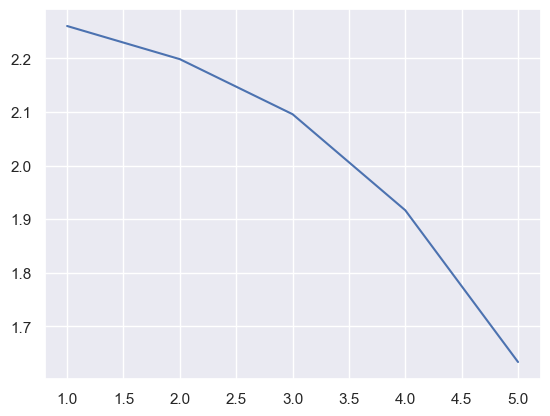

In [10]:
plt.plot([1,2,3,4,5], m.error_avg)